# Data-Driven Decision Making in SQL
* Extract information from an online movie rental company for operational decisions:
    * Popularity of actors to decide which movies to invest in
    * Revenue of the last months to estimate budget for short term investments
    * Success across countries to decide on market extensions
    * Longterm development of revenue for long term investments

* KPIs: Extract information which is relevant to measure the success of MovieNow:
    * Total number of rentals: revenue
    * The average rating of all movies: customer satisfaction
    * Number of active customers: customer engagement



## Importing Libraries

In [75]:
import psycopg2 as pg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Connect to PostgreSQL

In [76]:
def create_db_connection(host_name, user_name, user_password, db_name):
    conn = None
    try:
        conn = pg.connect(
            host=host_name,
            user = user_name,
            password = user_password,
            database = db_name
        )
        print("PostgreSQL '{}' Database connection successful".format(db_name))
    except Exception as e:
        print(f"Error: '{e}'")
    return conn

In [77]:
conn = create_db_connection('localhost', 'postgres', 'password', 'sqlda2')
cur = conn.cursor()

PostgreSQL 'sqlda2' Database connection successful


# Explore database
![](images/movienow.png)

In [78]:
q = """
select table_name, column_name, data_type
from information_schema.columns
where table_schema ='public'
order by table_name
"""

db_schema = pd.read_sql(q, conn)
db_schema

,table_name,column_name,data_type
0,actors,gender,character varying
1,actors,nationality,character varying
2,actors,year_of_birth,integer
3,actors,actor_id,integer
4,actors,name,character varying
5,actsin,actor_id,integer
6,actsin,actsin_id,integer
7,actsin,movie_id,integer
8,customers,country,character varying
9,customers,customer_id,integer


# What is the average rating per movie for those that have more than 5 ratings?

In [79]:
pd.read_sql('select * from renting', conn).isna().sum()

renting_id        0
customer_id       0
movie_id          0
rating          250
date_renting      0
dtype: int64

lots of missing values in `rating` since not every customer gives a rating after watching a movie

In [80]:
q = """
select title, avg(rating) as avg_rating, count(rating) as number_of_ratings
from movies
left join renting
on movies.movie_id = renting.movie_id
group by title
having count(rating) > 5 and avg(rating) is not null
order by avg(rating) desc
limit 10
"""
pd.read_sql(q,conn)

,title,avg_rating,number_of_ratings
0,Django Unchained,9.333333,6
1,Young Adult,8.833333,6
2,Imagining Argentina,8.666667,6
3,Harry Potter and the Half-Blood Prince,8.636364,11
4,Morning Glory,8.428571,7
5,Monster,8.285714,7
6,Harry Potter and the Deathly Hallows – Part 1,8.166667,6
7,Then She Found Me,8.166667,6
8,Winter's Bone,8.000000,8
9,Shall We Dance,8.000000,7


# Select all records of movie rentals between beginning of April 2018 till end of August 2018.

In [81]:
q = """
select movies.movie_id, title, renting.date_renting
from movies
left join renting
on movies.movie_id = renting.movie_id
where renting.date_renting between '2018-04-01' and '2018-08-31'
order by date_renting desc;
"""

pd.read_sql(q,conn)

,movie_id,title,date_renting
0,10,Simone,2018-08-31
1,62,The Sessions,2018-08-30
2,13,Harry Potter and the Chamber of Secrets,2018-08-29
3,32,A Good Woman,2018-08-28
4,68,The Company You Keep,2018-08-28
...,...,...,...
133,29,Two for the Money,2018-04-05
134,40,Then She Found Me,2018-04-05
135,58,The Help,2018-04-04
136,25,Bridget Jones - The Edge of Reason,2018-04-03


# Select the movies by increasing renting price

In [82]:
q = """
select *
from movies
order by renting_price
"""

pd.read_sql(q, conn)

,movie_id,title,genre,runtime,year_of_release,renting_price
0,42,No Country for Old Men,Drama,122,2007,1.49
1,16,25th Hour,Drama,135,2003,1.59
2,49,Harry Potter and the Half-Blood Prince,Science Fiction & Fantasy,153,2009,1.59
3,37,Candy,Drama,116,2006,1.59
4,36,World Trade Center,Drama,129,2006,1.59
...,...,...,...,...,...,...
66,32,A Good Woman,Drama,93,2006,2.89
67,52,Fair Game,Drama,108,2010,2.89
68,25,Bridget Jones - The Edge of Reason,Drama,108,2004,2.89
69,9,11'09''01 September 11,Drama,134,2002,2.99


# How many customers were born in the 80s?

In [83]:
q = """
select count(*)
from customers
where date_of_birth between '1980-01-01' AND '1989-12-31';
"""

pd.read_sql(q,conn)

,count
0,33


# How many customers are from Germany?

In [84]:
q = """
select count(*)
from customers
where country ='Germany'
"""

pd.read_sql(q,conn)

,count
0,0


In [85]:
q = """
select country, count(*)
from customers
group by country
"""
pd.read_sql(q,conn)

,country,count
0,Spain,16
1,Great Britan,10
2,Austria,4
3,Poland,13
4,Italy,27
5,Slovenia,11
6,Hungary,11
7,Denmark,7
8,Belgium,6
9,USA,4


# How many countries does MovieNow has customers?

In [86]:
q = """
select count(distinct(country))
from customers
"""

pd.read_sql(q,conn)

,count
0,11


# What was the date of the first account created for each country?

In [87]:
q = """
select country, min(date_account_start) as first_account
from customers
group by country
order by first_account;
"""

pd.read_sql(q,conn)

,country,first_account
0,France,2017-01-13
1,Hungary,2017-01-18
2,Belgium,2017-01-28
3,Slovenia,2017-01-31
4,Spain,2017-02-14
5,Italy,2017-02-28
6,Poland,2017-03-03
7,Great Britan,2017-03-31
8,Denmark,2017-04-30
9,USA,2017-09-13


# What is the average rating, number of ratings, and number of views for each movie?

In [88]:
q = """
select movie_id, avg(rating) as avg_rating, 
    count(rating) as number_ratings, 
    count(*) as number_rented
from renting
group by movie_id
having avg(rating) is not null
order by avg_rating desc;
"""

pd.read_sql(q,conn)

,movie_id,avg_rating,number_ratings,number_rented
0,48,10.000000,2,5
1,5,9.750000,4,8
2,42,9.600000,5,10
3,63,9.333333,6,11
4,65,9.000000,5,5
...,...,...,...,...
65,14,6.500000,6,11
66,68,6.333333,3,7
67,59,6.000000,2,5
68,43,6.000000,1,4


# Provide summary statistics of customer ratings with more than 7 movie rentals

In [89]:
q = """
select customer_id, avg(rating), count(rating), count(*)
from renting
group by customer_id
having count(*) > 7
order by avg(rating)
"""

pd.read_sql(q,conn)

,customer_id,avg,count,count
0,104,6.250000,4,8
1,28,6.714286,7,11
2,111,7.000000,3,10
3,113,7.000000,7,15
4,25,7.200000,5,10
5,21,7.333333,6,14
6,92,7.571429,7,11
7,49,7.625000,8,13
8,35,7.666667,6,9
9,52,7.875000,8,9


found out that customer number 104 gave the lowest average ratings for 4 movies.

# What is the average ratings of customers from Belgium?

In [90]:
q = """
select avg(r.rating)
from renting as r
left join customers as c
on r.customer_id = c.customer_id
where c.country='Belgium'
"""

pd.read_sql(q,conn)

,avg
0,8.9


# What is the revenue coming from movie rentals, the number of movie rentals and the number of customers who rented a movie?

In [91]:
q = """
select sum(renting_price) as revenue_rental,
count(*) as number_rentals,
count(distinct r.customer_id) as number_customers
from renting as r
left join movies as m
on r.movie_id = m.movie_id
"""

pd.read_sql(q, conn)

,revenue_rental,number_rentals,number_customers
0,1275.72,578,116


Total turnover is $1275.72 from a total number of 578 retnals and 116 active customers

# How much income did each movie generate?

In [92]:
q = """

select rm.title, sum(rm.renting_price) as income_movie
from (
    select m.title, m.renting_price
    from renting as r
    left join movies as m
    on r.movie_id = m.movie_id
    ) as rm

group by rm.title
order by income_movie desc;
"""

pd.read_sql(q,conn)


,title,income_movie
0,Bridget Jones - The Edge of Reason,37.57
1,Fair Game,34.68
2,The Kingdom,31.35
3,Two for the Money,30.69
4,Django Unchained,29.59
...,...,...
66,Harry Potter and the Chamber of Secrets,8.95
67,Jack and Jill,8.36
68,The Invasion,8.36
69,The Human Stain,7.96


# Which actors play most often in movies rented by male customers?

In [93]:
q = """
select a.name, 
count(*) as number_views,
avg(r.rating) as avg_rating

from renting as r
left join customers as c
on r.customer_id = c.customer_id
left join actsin as ai
on r.movie_id = ai.movie_id
left join actors as a
on ai.actor_id = a.actor_id

where c.gender = 'male'
group by a.name
having avg(r.rating) is not null
order by avg_rating desc, number_views desc;
"""

pd.read_sql(q,conn)

,name,number_views,avg_rating
0,Christian Bale,4,10.0
1,Kristen Bell,3,10.0
2,Marcia Gay Harden,3,10.0
3,Freddie Highmore,3,10.0
4,Ray Romano,3,10.0
...,...,...,...
125,Nick Stahl,3,5.0
126,Adam Sandler,3,5.0
127,Sam Riley,3,3.0
128,Andrea Riseborough,3,3.0


# What is the favourite movie for customers born in the 70s?

In [94]:
q = """
select m.title, count(*) as times_rented, avg(r.rating) as avg_rating

from renting as r
left join movies as m
on r.movie_id = m.movie_id
left join customers as c
on c.customer_id = r.customer_id
where c.date_of_birth between '1970-01-01' and '1980-01-01'

group by m.movie_id
having avg(r.rating) is not null

order by avg(r.rating) desc, count(*) desc
limit 10;
"""

pd.read_sql(q, conn)

,title,times_rented,avg_rating
0,Django Unchained,4,10.0
1,The Fighter,4,10.0
2,No Country for Old Men,3,10.0
3,One Night at McCool's,2,10.0
4,I'm Not There,2,10.0
5,The Fellowship of the Ring,2,10.0
6,Imagining Argentina,1,10.0
7,Astro Boy,1,10.0
8,Harry Potter and the Philosopher's Stone,1,10.0
9,The Lake House,1,10.0


# What is the total number of movie rentals, the average rating of all movies, and the total revenue for each country since the beginning of 2019?

In [95]:
q = """
select c.country, 
count(*) as total_rentals, 
avg(r.rating) as avg_rating,
sum(m.renting_price) as total_revenue
from renting as r
left join movies as m 
on r.movie_id = m.movie_id
left join customers as c
on c.customer_id = r.customer_id

where r.date_renting > '2019-1-1'
group by c.country
order by sum(m.renting_price) desc
"""

df = pd.read_sql(q,conn)
df

,country,total_rentals,avg_rating,total_revenue
0,Italy,30,8.235294,69.90
1,Spain,26,8.076923,57.94
2,Poland,21,8.125000,49.29
3,France,22,7.642857,48.38
4,Slovenia,14,8.000000,30.26
5,Hungary,10,7.166667,23.30
6,Great Britan,9,7.200000,17.91
7,Denmark,7,7.714286,14.63
8,USA,6,9.000000,14.54
9,Belgium,7,9.000000,13.13


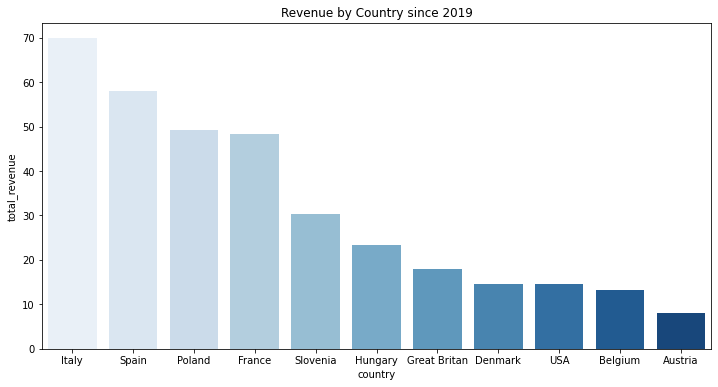

In [96]:
plt.figure(figsize=(12,6))

plt.title('Revenue by Country since 2019')
sns.barplot(df.country, df.total_revenue, palette='Blues');

# Manager wants a list of movies excluding those which are hardly ever watched. This list of movies will be used for advertising. List all movies with more than 5 views.

In [97]:
q = """
select *
from movies
where movie_id in
(select movie_id
from renting
group by movie_id
having count(*) > 5)
"""

pd.read_sql(q,conn)

,movie_id,title,genre,runtime,year_of_release,renting_price
0,1,One Night at McCool's,Comedy,93,2001,2.09
1,2,Swordfish,Drama,99,2001,2.19
2,3,What Women Want,Comedy,127,2001,2.59
3,4,Training Day,Drama,122,2001,1.79
4,5,The Fellowship of the Ring,Science Fiction & Fantasy,178,2001,2.59
5,6,Harry Potter and the Philosopher's Stone,Science Fiction & Fantasy,152,2001,2.69
6,7,The Royal Tenenbaums,Comedy,110,2002,1.89
7,10,Simone,Drama,117,2002,2.69
8,11,Showtime,Comedy,95,2002,1.79
9,12,The Two Towers,Science Fiction & Fantasy,179,2002,2.39


# Report a list of customers who frequently rent movies on MovieNow

In [98]:
q = """
select *
from customers 
where customer_id in

(select customer_id
from renting
group by customer_id
having count(*) > 10)
;
"""

pd.read_sql(q,conn)

,customer_id,name,country,gender,date_of_birth,date_account_start
0,21,Avelaine Corbeil,France,female,1986-03-17,2017-06-11
1,28,Sidney Généreux,France,male,1980-12-01,2017-02-04
2,49,Havasy Kristof,Hungary,male,1998-06-13,2017-01-18
3,92,Honorata Nowak,Poland,female,1986-05-02,2017-09-21
4,113,Lucy Centeno Barrios,Spain,female,1970-11-03,2017-06-13
5,114,Canela Gaona Lozano,Spain,female,1997-04-01,2017-02-14


# For the advertising campaign your manager also needs a list of popular movies with high ratings. Report a list of movies with rating above average.

In [99]:
q = """
select avg(rating) as avg_rating
from renting
"""

pd.read_sql(q,conn)

,avg_rating
0,7.939024


In [100]:
q = """
with cte as (
    select avg(rating) as avg_rating
    from renting
)


select m.title, avg(r.rating)
from renting as r
left join movies as m
on r.movie_id = m.movie_id
group by m.movie_id

having avg(r.rating) > (select avg_rating from cte)
order by avg(r.rating) desc
"""

pd.read_sql(q,conn)

,title,avg
0,Astro Boy,10.000000
1,The Fellowship of the Ring,9.750000
2,No Country for Old Men,9.600000
3,Django Unchained,9.333333
4,What Women Want,9.000000
5,Secondhand Lions,9.000000
6,Ghost Rider: Spirit of Vengeance,9.000000
7,Young Adult,8.833333
8,Harry Potter and the Philosopher's Stone,8.800000
9,Fool's Gold,8.750000


# Extract data of those customers with less than 5 movie rentals
* A new advertising campaign is going to focus on customers who rented fewer than 5 movies. 

In [101]:
q = """
with cte as (
select customer_id, count(*)
from renting
group by customer_id
having count(*) < 5
)

select *
from customers as c
where c.customer_id in (select customer_id from cte)
"""

pd.read_sql(q,conn)

,customer_id,name,country,gender,date_of_birth,date_account_start
0,2,Wolfgang Ackermann,Austria,male,1971-11-17,2018-10-15
1,3,Daniela Herzog,Austria,female,1974-08-07,2019-02-14
2,4,Julia Jung,Austria,female,1991-01-04,2017-11-22
3,5,Juliane Kirsch,Austria,female,1977-03-01,2018-12-16
4,6,Rowanne Couperus,Belgium,female,1994-04-05,2018-08-26
5,11,Yakup Mes,Belgium,male,1978-04-28,2019-02-19
6,12,Kristine J. Lauritsen,Denmark,female,1994-01-14,2018-12-02
7,14,Niels M. Holm,Denmark,male,1991-12-29,2018-01-26
8,15,Jasmin M. Krogh,Denmark,female,1977-11-12,2018-06-20
9,16,Sofia J. Pedersen,Denmark,female,1990-05-27,2018-10-02


# Report a list of customers with minimum rating smaller than 4.

In [102]:
q = """
select *
from customers as c
where 4 >

(select min(rating)
from renting as r
where r.customer_id = c.customer_id
);
"""

pd.read_sql(q,conn)

,customer_id,name,country,gender,date_of_birth,date_account_start
0,28,Sidney Généreux,France,male,1980-12-01,2017-02-04
1,41,Zara Mitchell,Great Britan,female,1994-07-08,2017-06-12
2,86,Albin Jaworski,Poland,male,1984-05-01,2017-12-15
3,120,Robin J. Himes,USA,male,1988-11-30,2018-08-06


# Give an overview of the number of customers for a presentation.
* Generate a table with the total number of customers, the number of customers for each country, and the number of female and male customers for each country.

In [103]:
q = """
select country,
gender,count(*)
from customers
group by rollup (country, gender)
order by country, gender
"""

pd.read_sql(q,conn)

,country,gender,count
0,Austria,female,3
1,Austria,male,1
2,Austria,None,4
3,Belgium,female,3
4,Belgium,male,3
5,Belgium,None,6
6,Denmark,female,4
7,Denmark,male,3
8,Denmark,None,7
9,France,female,5


# Analyzing preferences of genres across countries
* Are there particular genres which are more popular in specific countries?
* Evaluate the preferences of customers by averaging their ratings and counting the number of movies rented from each genre.

In [104]:
q = """
select c.country, 
m.genre,
avg(r.rating) as avg_rating,
count(*) as num_rating

from renting as r
left join movies as m
on r.movie_id = m.movie_id
left join customers as c
on c.customer_id = r. customer_id

group by rollup (c.country, m.genre)

order by c.country, m.genre
;
"""


pd.read_sql(q,conn)

,country,genre,avg_rating,num_rating
0,Austria,Comedy,8.000000,1
1,Austria,Drama,6.000000,2
2,Austria,Mystery & Suspense,NaN,1
3,Austria,Science Fiction & Fantasy,6.666667,3
4,Austria,None,6.800000,7
...,...,...,...,...
83,None,Comedy,NaN,1
84,None,Drama,6.000000,2
85,None,Science Fiction & Fantasy,NaN,1
86,None,None,7.939024,578
